In [ ]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics
!pip install squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 12.6 MB/s eta 0:00:00


In [ ]:
import os
import csv
import tensorflow as tf
import keras as keras
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import squarify
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import sklearn
import ultralytics
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

sns.set_style('darkgrid')

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reproducibility
random_seed = 42
random.seed(random_seed)

# Show versions of the imported libraries
pd.DataFrame({
    'Library': ['ultralytics','tensorflow','keras','csv','cv2','pandas','matplotlib','sklearn','sns'],
    'Version': [ultralytics.__version__,tf.__version__,keras.__version__,csv.__version__,cv2.__version__,pd.__version__,matplotlib.__version__,sklearn.__version__,sns.__version__]
})


Library Version
0  ultralytics  8.2.92
1   tensorflow  2.17.0
2        keras   3.4.1
3          csv     1.0
4          cv2  4.10.0
5       pandas   2.1.4
6   matplotlib   3.7.1
7      sklearn   1.3.2
8          sns  0.13.1

In [ ]:
def csv_to_dataframe(csv_filepath, columns_name):
    df = pd.read_csv(csv_filepath, names=columns_name, header=0)
    return df

def calc_percentage(df_total, df_part,file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100

def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                 yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)

def create_yaml_data(yaml_file_name,output_dir,data):
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, f'{yaml_file_name}.yaml')
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')

def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data = {}
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
        if image_id not in data:
            data[image_id] = []
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')

def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')

def leaf_detect(img_path,model):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    return detect_img

def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
    plt.show()

def show_csv_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
    sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
    sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
    sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
    sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
    sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
    sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
    sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
    sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
    sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])
    axs[0,0].set(title='Train Box Loss')
    axs[0,1].set(title='Train Class Loss')
    axs[1,0].set(title='Train DFL Loss')
    axs[1,1].set(title='Metrics Precision (B)')
    axs[2,0].set(title='Metrics Recall (B)')
    axs[2,1].set(title='Metrics mAP50 (B)')
    axs[3,0].set(title='Metrics mAP50-95 (B)')
    axs[3,1].set(title='Validation Box Loss')
    axs[4,0].set(title='Validation Class Loss')
    axs[4,1].set(title='Validation DFL Loss')
    plt.suptitle('Training Metrics and Loss', fontsize=24)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()

def show_directory_images(directory, num_images, rows=3, columns=3):
    archivos_imagen = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(archivos_imagen))):
        img_path = os.path.join(directory, archivos_imagen[i])
        img = cv2.imread(img_path)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(img)
        ax.axis('off')
    for j in range(num_images, rows * columns):
        ax = fig.add_subplot(rows, columns, j + 1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_metrics(metrics):
    # Create the barplot
    ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])
    # Set the title and axis labels
    ax.set_title('YOLO Evaluation Metrics')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    # Set the figure size
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    # Add the values on top of the bars
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    # Show the plot
    plt.show()

def show_detections(images_dir, num_images=16, rows=4, columns=4):
    image_files = os.listdir(images_dir)
    selected_images = random.sample(image_files, num_images)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))
    for i, img_file in enumerate(selected_images):
        row_idx = i // columns
        col_idx = i % columns
        img_path = os.path.join(images_dir, img_file)
        detect_img = leaf_detect(img_path, model)
        axes[row_idx, col_idx].imshow(detect_img)
        axes[row_idx, col_idx].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

def show_image(img_path):
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [ ]:
columns_name = ['image_id', 'width', 'height', 'bbox']
csv_filepath = '/content/drive/MyDrive/project/leaf_detection/train.csv'
annotations = csv_to_dataframe(csv_filepath,columns_name)
df = pd.DataFrame(annotations)

# Split the DataFrame into training(80%) and validation with test(20%) based on the unique file names
unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=random_seed)
train_df = df[df['image_id'].isin(train_filenames)]

# 10% for validation and 10% for test
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=0.5, random_state=random_seed)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]

In [ ]:
train_percentage = calc_percentage(df,train_df,'image_id')
print(f'Elements in train_df({train_percentage}%):',len(train_df['image_id'].unique()))
train_df.head()

Elements in train_df(80.0%): 904


image_id  width  height                  bbox
0  LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1  LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2  LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3  LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4  LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]

In [ ]:
val_percentage = calc_percentage(df,val_df,'image_id')
print(f'Elements in val_df({val_percentage}%):',len(val_df['image_id'].unique()))
val_df.head()

Elements in val_df(10.0%): 113


image_id  width  height                  bbox
172  LEAF_0012.jpg   1024    1024  [498, 185, 192, 301]
173  LEAF_0012.jpg   1024    1024  [357, 182, 154, 287]
174  LEAF_0012.jpg   1024    1024  [328, 482, 185, 243]
175  LEAF_0012.jpg   1024    1024  [503, 498, 173, 254]
176  LEAF_0012.jpg   1024    1024  [123, 255, 111, 203]

In [ ]:
test_percentage = calc_percentage(df,test_df,'image_id')
print(f'Elements in test_df({test_percentage}%):',len(test_df['image_id'].unique()))
test_df.head()

Elements in test_df(10.0%): 113


image_id  width  height                  bbox
307  LEAF_0019.jpg   1024    1024  [722, 298, 302, 209]
308  LEAF_0019.jpg   1024    1024  [747, 459, 277, 166]
309  LEAF_0019.jpg   1024    1024  [870, 700, 154, 324]
310  LEAF_0019.jpg   1024    1024  [696, 655, 171, 200]
311  LEAF_0019.jpg   1024    1024  [421, 810, 222, 214]

In [ ]:
output_dir = '/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection'
yaml_file_name = 'data'
yaml_data = {
    'train': f'{output_dir}/train/images',
    'val': f'{output_dir}/valid/images',
    'test': f'{output_dir}/test/images',
    'format':'line_break',
    'nc': 1,
    'names': ['leaf']
}

create_yaml_data(yaml_file_name,output_dir,yaml_data)

YAML file created successfully in /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/data.yaml.


In [ ]:
paths_all_images = '/content/drive/MyDrive/project/leaf_detection/train_origin/'

# Data for train
txt_files_train = f'{output_dir}/train/labels'
img_files_train = f'{output_dir}/train/images'
move_images_to_directory(train_df, paths_all_images, img_files_train)
dataframe_yolofiles(train_df, txt_files_train)

# Data for validation
txt_files_val = f'{output_dir}/valid/labels'
img_files_val = f'{output_dir}/valid/images'
move_images_to_directory(val_df, paths_all_images, img_files_val)
dataframe_yolofiles(val_df, txt_files_val)

# Data for test
txt_files_test = f'{output_dir}/test/labels'
img_files_test = f'{output_dir}/test/images'
move_images_to_directory(test_df, paths_all_images, img_files_test)
dataframe_yolofiles(test_df, txt_files_test)

Total images moved to: /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/train/images
Total text files created in: /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/train/labels
Total images moved to: /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/valid/images
Total text files created in: /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/valid/labels
Total images moved to: /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/test/images
Total text files created in: /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/test/labels


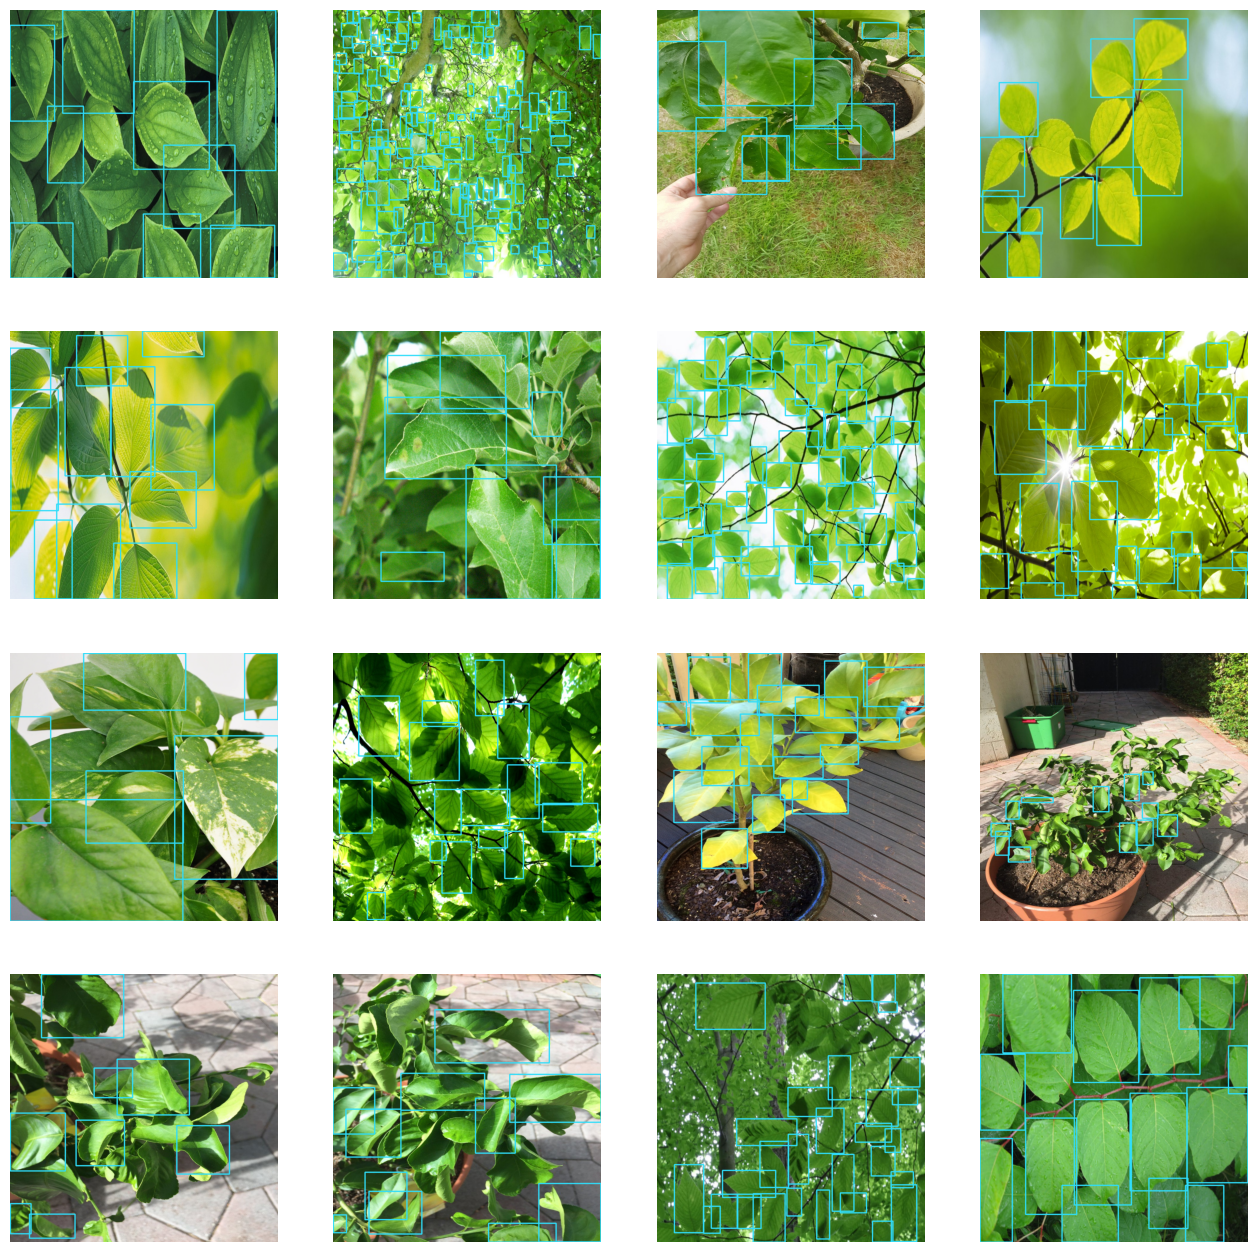

In [ ]:
# Define the paths to the images and labels directories
train_images = "/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/train/images"
train_labels = "/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/train/labels"

test_images = "/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/test/images"
test_labels = "/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/test/labels"

val_images = "/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/valid/images"
val_labels = "/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/valid/labels"


plot_images_with_detections(train_images, train_labels)

In [ ]:
# Load an image using OpenCV
image = cv2.imread("/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/train/images/LEAF_1171.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")


The image has dimensions 1024x1024 and 3 channels.


In [ ]:
 # Loading a pretrained model
model = YOLO('yolov8n.pt')

# Training the model
#model.train(data = 'yolo_dataset_leafdetection/data.yaml',
model.train(data = '/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/data.yaml',
            epochs = 60,
            imgsz = height,
            seed = random_seed,
            batch = 8,
            workers = 4)

100%|██████████| 6.25M/6.25M [00:00<00:00, 379MB/s]

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/data.yaml, epochs=60, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, f

100%|██████████| 755k/755k [00:00<00:00, 88.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/train/labels.cache... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/valid/labels.cache... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.37G      1.455      2.305      1.729         49       1024: 100%|██████████| 113/113 [00:16<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        113        532      0.422      0.418      0.379      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.49G      1.501      2.066      1.752         67       1024: 100%|██████████| 113/113 [00:13<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]


                   all        113        532      0.378       0.34      0.259      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60       3.4G      1.557       1.98      1.802         51       1024: 100%|██████████| 113/113 [00:13<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.39it/s]


                   all        113        532      0.422      0.391      0.347      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60         3G      1.515      1.826      1.796         57       1024: 100%|██████████| 113/113 [00:12<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]

                   all        113        532      0.437      0.414       0.36      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.55G      1.479      1.709      1.748         52       1024: 100%|██████████| 113/113 [00:13<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        113        532      0.424      0.447      0.414      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.39G      1.508      1.707      1.774         72       1024: 100%|██████████| 113/113 [00:13<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]

                   all        113        532      0.397      0.451       0.36      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.39G       1.47      1.675      1.722         85       1024: 100%|██████████| 113/113 [00:13<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

                   all        113        532      0.409      0.551      0.438      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.68G      1.437      1.607      1.709         47       1024: 100%|██████████| 113/113 [00:13<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

                   all        113        532      0.462      0.466      0.426      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.43G      1.408      1.544      1.692         52       1024: 100%|██████████| 113/113 [00:12<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.05it/s]

                   all        113        532      0.528      0.432      0.436       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.03G      1.373      1.502      1.678         50       1024: 100%|██████████| 113/113 [00:12<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]

                   all        113        532      0.494      0.475      0.466      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.53G      1.409      1.546      1.689         56       1024: 100%|██████████| 113/113 [00:13<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        113        532      0.484      0.571       0.48      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.03G       1.36      1.459      1.656         30       1024: 100%|██████████| 113/113 [00:13<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

                   all        113        532      0.513      0.564       0.52       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.36G      1.357      1.479      1.659         38       1024: 100%|██████████| 113/113 [00:13<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

                   all        113        532       0.53      0.445       0.44      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.19G      1.374      1.473      1.673         50       1024: 100%|██████████| 113/113 [00:13<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

                   all        113        532      0.552      0.506      0.515      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.37G      1.337      1.403      1.643         80       1024: 100%|██████████| 113/113 [00:13<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

                   all        113        532      0.537      0.524      0.515      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.53G      1.319      1.381       1.62         36       1024: 100%|██████████| 113/113 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        113        532      0.602      0.511      0.524      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.24G      1.331      1.395      1.647         68       1024: 100%|██████████| 113/113 [00:13<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        113        532      0.543      0.515      0.512      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.92G      1.314      1.341      1.624         52       1024: 100%|██████████| 113/113 [00:13<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

                   all        113        532       0.56       0.53      0.535      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       3.5G      1.313      1.328      1.619         48       1024: 100%|██████████| 113/113 [00:13<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        113        532      0.467      0.605      0.538      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.41G      1.262      1.297      1.579         52       1024: 100%|██████████| 113/113 [00:13<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]

                   all        113        532       0.59      0.516      0.527        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.18G      1.277      1.302      1.579         89       1024: 100%|██████████| 113/113 [00:13<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        113        532       0.52      0.563      0.561      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.58G      1.259      1.281      1.568         66       1024: 100%|██████████| 113/113 [00:13<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        113        532      0.577      0.524      0.548      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.13G      1.264      1.257      1.546         44       1024: 100%|██████████| 113/113 [00:13<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

                   all        113        532      0.522      0.578      0.529      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.48G      1.259      1.238      1.575         43       1024: 100%|██████████| 113/113 [00:13<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        113        532      0.553      0.564      0.562       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.19G      1.238      1.237      1.559         36       1024: 100%|██████████| 113/113 [00:12<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]

                   all        113        532      0.541      0.592      0.553      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.46G      1.231      1.205      1.541         45       1024: 100%|██████████| 113/113 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

                   all        113        532      0.515      0.633      0.585      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.06G      1.236      1.208      1.565         40       1024: 100%|██████████| 113/113 [00:12<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

                   all        113        532      0.545      0.628      0.591      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.42G       1.22      1.207      1.542         56       1024: 100%|██████████| 113/113 [00:13<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]

                   all        113        532      0.551      0.502      0.549      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.93G      1.212      1.175      1.518        103       1024: 100%|██████████| 113/113 [00:13<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

                   all        113        532      0.485      0.624      0.542      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.51G      1.206      1.203       1.52         98       1024: 100%|██████████| 113/113 [00:13<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

                   all        113        532      0.523      0.626      0.578      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.47G       1.19      1.163      1.521         28       1024: 100%|██████████| 113/113 [00:13<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]

                   all        113        532      0.605      0.622      0.608      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.59G      1.202       1.15      1.529         71       1024: 100%|██████████| 113/113 [00:12<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.00it/s]

                   all        113        532      0.549      0.588      0.581      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.36G      1.212      1.132      1.509         77       1024: 100%|██████████| 113/113 [00:13<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        113        532      0.553      0.635      0.572      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.58G      1.192      1.145      1.499        116       1024: 100%|██████████| 113/113 [00:13<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]

                   all        113        532      0.599      0.556      0.589      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.47G      1.175      1.132      1.508         63       1024: 100%|██████████| 113/113 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]

                   all        113        532      0.621      0.565      0.577      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.44G      1.183      1.105      1.486         77       1024: 100%|██████████| 113/113 [00:13<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

                   all        113        532      0.615      0.555      0.604      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.72G      1.162      1.109      1.502         39       1024: 100%|██████████| 113/113 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

                   all        113        532      0.569      0.571      0.569      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.76G      1.158      1.092      1.482         26       1024: 100%|██████████| 113/113 [00:13<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.07it/s]

                   all        113        532      0.594       0.57      0.579      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.14G      1.171      1.088      1.473         93       1024: 100%|██████████| 113/113 [00:13<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]

                   all        113        532      0.592      0.613      0.604      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.01G      1.146      1.069      1.457         32       1024: 100%|██████████| 113/113 [00:13<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        113        532      0.574      0.615      0.597      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.64G      1.137      1.055      1.448         52       1024: 100%|██████████| 113/113 [00:13<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]

                   all        113        532      0.565      0.637      0.586      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.66G      1.126       1.05       1.46         49       1024: 100%|██████████| 113/113 [00:13<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]

                   all        113        532      0.579      0.624      0.605      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.75G      1.138      1.046      1.452         47       1024: 100%|██████████| 113/113 [00:13<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

                   all        113        532       0.59       0.63      0.609      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.19G      1.073     0.9901      1.434         64       1024: 100%|██████████| 113/113 [00:13<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        113        532      0.586       0.63      0.627      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.44G      1.138      1.052      1.449        106       1024: 100%|██████████| 113/113 [00:13<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]

                   all        113        532      0.624      0.607      0.618      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.58G      1.101      0.998      1.425        168       1024: 100%|██████████| 113/113 [00:13<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        113        532      0.628      0.664      0.624      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.21G       1.09      1.009      1.424         78       1024: 100%|██████████| 113/113 [00:13<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

                   all        113        532      0.615      0.628      0.635      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.25G      1.081     0.9517      1.429         50       1024: 100%|██████████| 113/113 [00:13<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.96it/s]

                   all        113        532      0.604      0.639      0.622      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60       3.5G      1.087     0.9856      1.407         60       1024: 100%|██████████| 113/113 [00:13<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

                   all        113        532      0.632      0.613      0.631      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.77G      1.057     0.9421        1.4         64       1024: 100%|██████████| 113/113 [00:12<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

                   all        113        532      0.657      0.592      0.649      0.411


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.94G      1.083     0.9564      1.436         26       1024: 100%|██████████| 113/113 [00:14<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

                   all        113        532      0.678      0.611      0.648       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.44G      1.044     0.9046      1.426         29       1024: 100%|██████████| 113/113 [00:12<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        113        532      0.629      0.665      0.653      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.97G      1.039     0.8759      1.404         30       1024: 100%|██████████| 113/113 [00:12<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        113        532      0.683      0.617       0.66      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.68G      1.014     0.8551      1.383        146       1024: 100%|██████████| 113/113 [00:12<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

                   all        113        532      0.648      0.665      0.656       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.82G      1.032     0.8665      1.411         24       1024: 100%|██████████| 113/113 [00:12<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

                   all        113        532      0.633      0.665       0.66      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.06G      1.001     0.8428      1.389         15       1024: 100%|██████████| 113/113 [00:12<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

                   all        113        532      0.691      0.602      0.652      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.63G      1.011     0.8287      1.387         23       1024: 100%|██████████| 113/113 [00:12<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.01it/s]

                   all        113        532      0.668       0.62      0.659       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.96G      0.992     0.8085      1.348         20       1024: 100%|██████████| 113/113 [00:12<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

                   all        113        532      0.616      0.658      0.648      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60       3.7G     0.9795     0.8081      1.366         66       1024: 100%|██████████| 113/113 [00:12<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.75it/s]

                   all        113        532      0.633      0.637      0.657      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.31G      0.973     0.8046      1.354         21       1024: 100%|██████████| 113/113 [00:12<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

                   all        113        532      0.612      0.662      0.654       0.42



60 epochs completed in 0.247 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


                   all        113        532      0.683      0.617      0.661      0.427
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6148a3b8b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

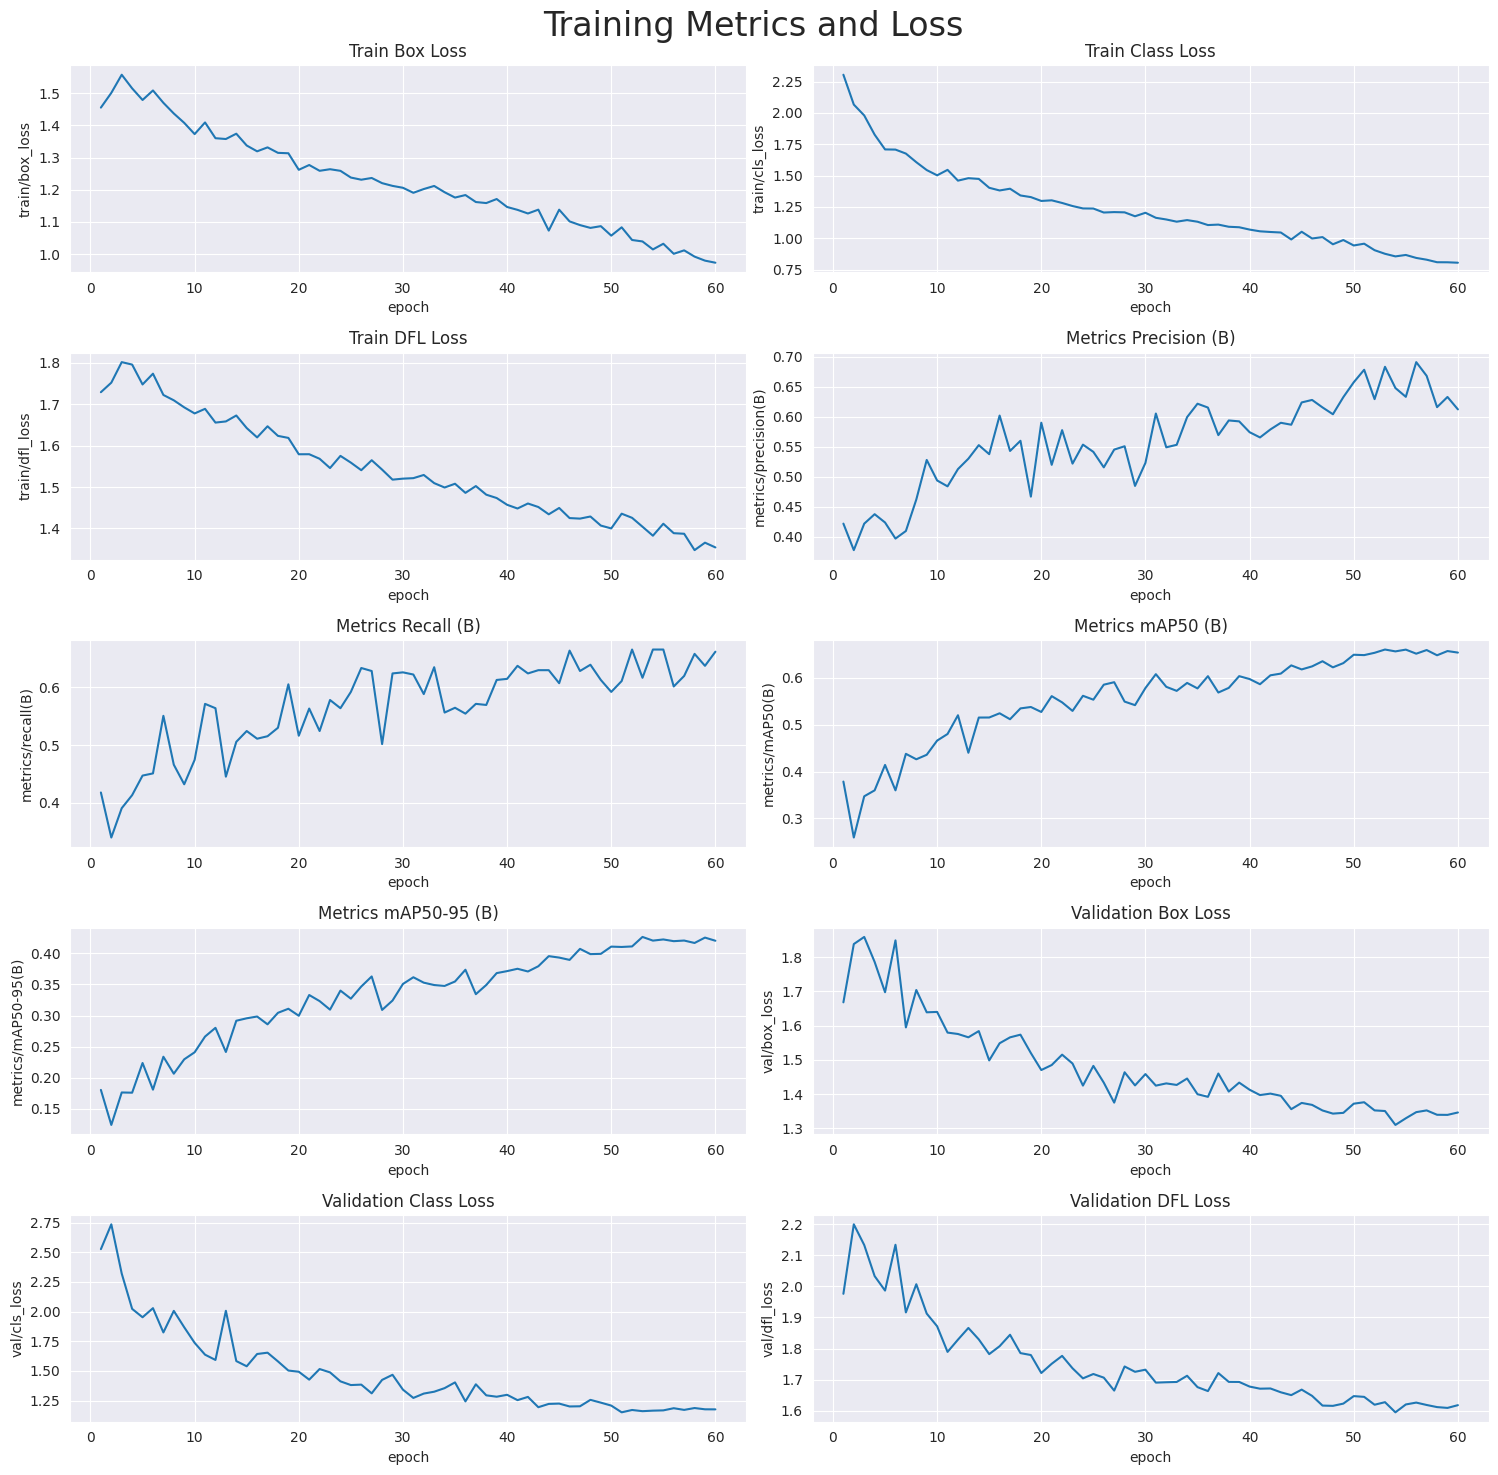

In [ ]:
csv_path = 'runs/detect/train/results.csv'
show_csv_results(csv_path)

In [ ]:
model = YOLO('runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/project/leaf_detection/yolo_dataset_leafdetection/test/labels.cache... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


                   all        113        626       0.65      0.725      0.714      0.494
Speed: 0.8ms preprocess, 7.2ms inference, 0.0ms loss, 28.3ms postprocess per image
Results saved to runs/detect/val


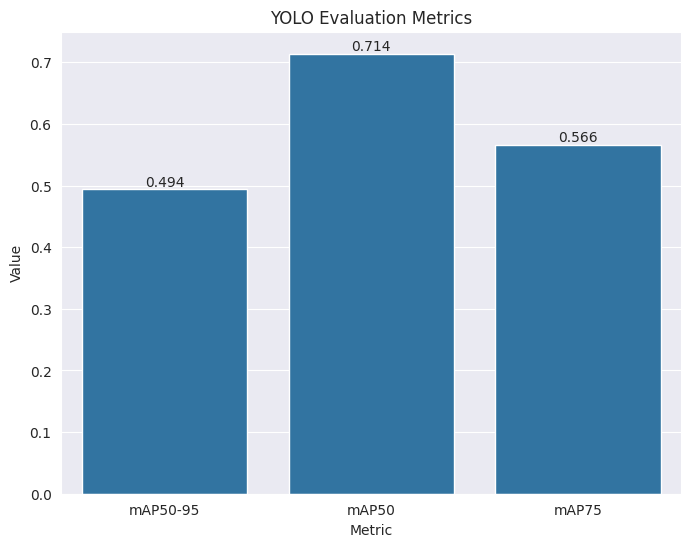

In [ ]:
# Show evaluation metrics
show_metrics(metrics)

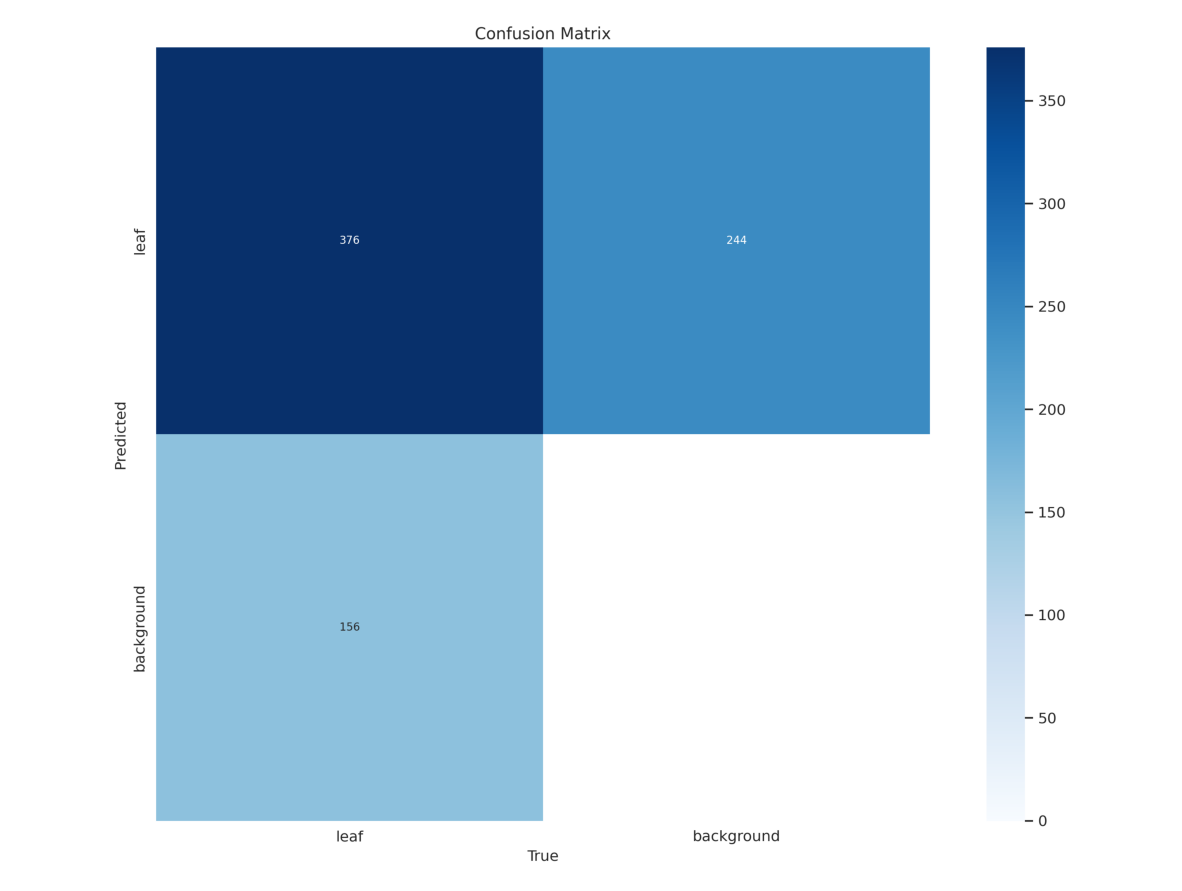

In [ ]:
# Reading the confusion matrix image file
matrix_path='runs/detect/train/confusion_matrix.png'
# Plotting the confusion matrix image
show_image(matrix_path)


0: 1024x1024 5 leafs, 10.9ms
Speed: 5.2ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 77 leafs, 8.9ms
Speed: 4.0ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 74 leafs, 7.4ms
Speed: 4.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 16 leafs, 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 54 leafs, 7.5ms
Speed: 4.0ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 25 leafs, 7.4ms
Speed: 4.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 63 leafs, 7.8ms
Speed: 4.0ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)


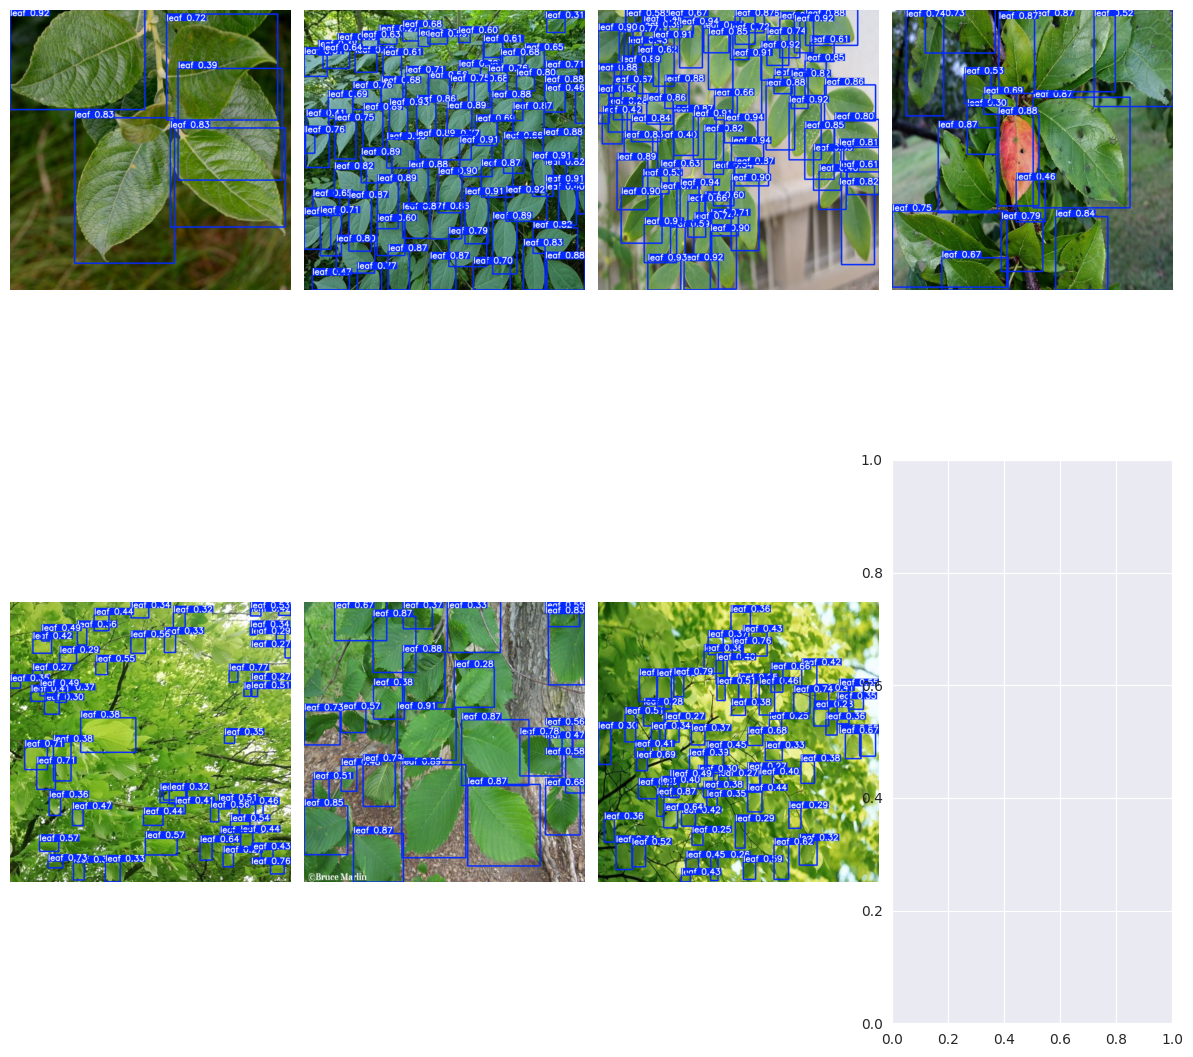

In [ ]:
custom_image_dir = '/content/drive/MyDrive/project/leaf_detection/leaf'

# Detect and display predictions
show_detections(custom_image_dir,num_images=7, rows=2, columns=4)

In [ ]:
model = YOLO('runs/detect/train/weights/best.pt')  # Loading the best performing model
model.export(format='tflite')

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 5, 21504) (6.0 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 253.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 325.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 294.1 MB/s 

100%|██████████| 1.11M/1.11M [00:00<00:00, 203MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 46.15file/s]

requirements: Ultralytics requirement ['onnxslim==0.1.32'] not found, attempting AutoUpdate...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: onnxslim
    Found existing installation: onnxslim 0.1.33
    Uninstalling onnxslim-0.1.33:
      Successfully uninstalled onnxslim-0.1.33

requirements: AutoUpdate success ✅ 2.5s, installed 1 package: ['onnxslim==0.1.32']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: slimming with onnxslim 0.1.32...
ONNX: export success ✅ 3.7s, saved as 'runs/detect/train/weights/best.onnx' (12.2 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 108.0s, saved as 'runs/detect/train/weights/best_saved_model' (30.3 MB)

TensorFlow Lite: starting export with tensorflow 2.17.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/detect/train/weights/best_saved_model/best_float32.tflite' (12.0 MB)

Export complete (109.6s)
Results saved to /content/

'runs/detect/train/weights/best_saved_model/best_float32.tflite'

In [ ]:
model = YOLO('/content/drive/MyDrive/backup/weights/best.pt')
model.export(format='tflite', imgsz=480)

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/backup/weights/best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 5, 4725) (6.0 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 201.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 248.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 234.1 

100%|██████████| 1.11M/1.11M [00:00<00:00, 122MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 49.45file/s]

requirements: Ultralytics requirement ['onnxslim==0.1.32'] not found, attempting AutoUpdate...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 50.0 MB/s eta 0:00:00
  Attempting uninstall: onnxslim
    Found existing installation: onnxslim 0.1.33
    Uninstalling onnxslim-0.1.33:
      Successfully uninstalled onnxslim-0.1.33

requirements: AutoUpdate success ✅ 3.5s, installed 1 package: ['onnxslim==0.1.32']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: slimming with onnxslim 0.1.32...
ONNX: export success ✅ 6.2s, saved as '/content/drive/MyDrive/backup/weights/best.onnx' (11.7 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 36.1s, saved as '/content/drive/MyDrive/backup/weights/best_saved_model' (29.2 MB)

TensorFlow Lite: starting export with tensorflow 2.17.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/content/drive/MyDrive/backup/weights/best_saved_model/best_float32.tflite' (11.6 MB)

Export complete 

'/content/drive/MyDrive/backup/weights/best_saved_model/best_float32.tflite'

In [ ]:
!cp -r runs/detect/train/ /content/drive/MyDrive/backup/

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import shutil

# 복사할 폴더와 목적지 경로를 지정합니다.
src = 'runs/detect/train/'
dst = '/content/drive/MyDrive/backup/runs/detect/train/'

# 파일 및 디렉토리 복사
shutil.copytree(src, dst)

'/content/drive/MyDrive/backup/runs/detect/train/'

In [ ]:
# Load a pretrained YOLOv8n model
model = YOLO('runs/detect/train/weights/best_saved_model/best_float32.tflite')

# Run inference
model.predict('/content/drive/MyDrive/project/leaf_detection/train_origin/LEAF_0009.jpg', save=True, imgsz=height, conf=0.2)

Loading runs/detect/train/weights/best_saved_model/best_float32.tflite for TensorFlow Lite inference...

image 1/1 /content/drive/MyDrive/project/leaf_detection/train_origin/LEAF_0009.jpg: 1024x1024 17 leafs, 434.0ms
Speed: 4.1ms preprocess, 434.0ms inference, 16.7ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'leaf'}
 obb: None
 orig_img: array([[[ 39,  76,  42],
         [ 39,  76,  42],
         [ 39,  76,  42],
         ...,
         [ 97, 197, 149],
         [ 88, 195, 146],
         [ 79, 190, 138]],
 
        [[ 40,  77,  43],
         [ 39,  76,  42],
         [ 40,  77,  43],
         ...,
         [103, 202, 154],
         [ 94, 201, 152],
         [ 77, 188, 136]],
 
        [[ 41,  79,  43],
         [ 39,  77,  41],
         [ 40,  78,  42],
         ...,
         [111, 205, 158],
         [ 95, 200, 151],
         [ 82, 192, 140]],
 
        ...,
 
        [[ 55, 130,  79],
         [ 57, 132,  81],
         [ 65, 139,  87],
         ...,
         [ 60, 114,  61],
         [ 67, 116,  64],
         [ 67, 116,  64]],
 
        [[ 54, 131,  80],
         [ 54, 129,  78],
         [ 64, 137,  87],
         ...,
         [ 54, 108, 

In [ ]:
/content/drive/MyDrive/project/leaf_detection/train_origin/LEAF_0009.jpg